In [116]:
import numpy as np
import matplotlib.pyplot as plt
from typing import Dict, List, Tuple, Optional

class GridMap:
    def __init__(self, size: int = 50, seed: int = 42):
        """
        비정형 그리드 맵 초기화
        
        Args:
            size (int): 맵의 크기 (size x size)
            seed (int): 랜덤 시드 값
        """
        self.size = size
        # padding을 포함한 실제 맵 크기 (양쪽에 2칸씩 추가)
        self.padded_size = size + 4
        # 0: 일반 경로, 1: 장애물, 2: 공사중인 경로
        self.grid = np.zeros((self.padded_size, self.padded_size))
        # 지름길 정보를 저장할 딕셔너리 {(x1, y1): (x2, y2)} 형태로 저장
        self.shortcuts: Dict[Tuple[int, int], Tuple[int, int]] = {}
        # 랜덤 시드 설정
        np.random.seed(seed)
        
        # padding 영역을 장애물로 설정
        self._add_padding()

    def _add_padding(self):
        """맵의 경계에 2칸의 padding 추가"""
        # 상단 padding
        self.grid[0:2, :] = 1
        # 하단 padding
        self.grid[-2:, :] = 1
        # 좌측 padding
        self.grid[:, 0:2] = 1
        # 우측 padding
        self.grid[:, -2:] = 1
    

    def add_random_shortcuts(self, num_shortcuts: int, agent_pos: Optional[Tuple[int, int]] = None):
        """
        랜덤한 크기와 위치의 지름길들을 생성
        시작 위치를 기준으로 도착 위치는 offset으로 계산
        offset의 크기는 2x2부터 5x5 사이에서 랜덤하게 결정되며, 정사각형이 아닐 수 있음
        지름길은 양방향으로 생성될 수 있음 (오른쪽/왼쪽, 위/아래)
        
        Args:
            num_shortcuts (int): 생성할 지름길의 개수
            agent_pos (Tuple[int, int], optional): 에이전트의 위치 (x, y)
        """
        successful_shortcuts = 0
        attempts = 0
        max_attempts = num_shortcuts * 100  # 무한 루프 방지를 위한 최대 시도 횟수
        
        while successful_shortcuts < num_shortcuts and attempts < max_attempts:
            attempts += 1  # 시도 횟수 증가
            
            # 랜덤한 크기 생성 (2~4)
            size_x = np.random.randint(2, 5)
            size_y = np.random.randint(2, 5)
            
            # 랜덤한 시작 위치 생성 (맵을 벗어나지 않도록)
            start_x = np.random.randint(0, self.size - size_x + 1)
            start_y = np.random.randint(0, self.size - size_y + 1)
            
            # 방향 랜덤 선택 (오른쪽/왼쪽, 위/아래)
            direction_x = np.random.choice([-1, 1])  # -1: 왼쪽, 1: 오른쪽
            direction_y = np.random.choice([-1, 1])  # -1: 위, 1: 아래
            
            # 도착 위치 계산
            end_x = start_x + (size_x * direction_x)
            end_y = start_y + (size_y * direction_y)
            
            # 도착 위치가 맵을 벗어나는 경우 스킵
            if end_x < 0 or end_x >= self.size or end_y < 0 or end_y >= self.size:
                continue
            
            # 에이전트 위치와 겹치는지 확인
            if agent_pos:
                agent_x, agent_y = agent_pos
                if ((start_x <= agent_x < start_x + size_x) and (start_y <= agent_y < start_y + size_y)) or \
                ((end_x <= agent_x < end_x + size_x) and (end_y <= agent_y < end_y + size_y)):
                    continue
            
            # 이미 장애물이나 공사중인 경로가 있는 영역인지 확인
            if self._is_area_occupied(start_x, start_y, size_x, size_y) or \
            self._is_area_occupied(end_x, end_y, size_x, size_y):
                continue
            
            # 이미 존재하는 지름길과 겹치는지 확인
            if self._is_shortcut_overlapping(start_x, start_y, size_x, size_y) or \
            self._is_shortcut_overlapping(end_x, end_y, size_x, size_y):
                continue
            
            # 지름길 추가(패딩을 고려한 좌표 사용)
            self.shortcuts[(start_x+2, start_y+2)] = (end_x+2, end_y+2)
            successful_shortcuts += 1  # 성공한 경우에만 카운트 증가

    def _is_shortcut_overlapping(self, x: int, y: int, size_x: int, size_y: int) -> bool:
        """
        특정 영역에 이미 지름길이 있는지 확인
        
        Args:
            x (int): 시작 x 좌표
            y (int): 시작 y 좌표
            size_x (int): 영역의 가로 크기
            size_y (int): 영역의 세로 크기
        
        Returns:
            bool: 영역이 점유되어 있으면 True, 아니면 False
        """
        # padding을 고려한 좌표 조정
        x += 2
        y += 2
        
        for start, end in self.shortcuts.items():
            # 시작점 영역 확인
            if (x <= start[0] < x + size_x) and (y <= start[1] < y + size_y):
                return True
            # 도착점 영역 확인
            if (x <= end[0] < x + size_x) and (y <= end[1] < y + size_y):
                return True
        return False


    def add_obstacle(self, x: int, y: int, width: int = 1, height: int = 1):
        """
        다양한 크기의 장애물 추가
        
        Args:
            x (int): 장애물의 시작 x 좌표
            y (int): 장애물의 시작 y 좌표
            width (int): 장애물의 가로 크기 (1~3)
            height (int): 장애물의 세로 크기 (1~3)
        """
        # padding을 고려한 좌표 조정
        x += 2
        y += 2
        
        # 크기 제한 확인
        width = max(1, min(3, width))
        height = max(1, min(3, height))
        
        # 맵 범위 확인
        if x + width > self.padded_size or y + height > self.padded_size:
            return
        
        # 장애물 영역 설정
        self.grid[x:x+width, y:y+height] = 1

    def add_random_obstacles(self, num_obstacles: int, agent_pos: Optional[Tuple[int, int]] = None):
        """
        랜덤한 크기와 위치의 장애물들을 생성
        
        Args:
            num_obstacles (int): 생성할 장애물의 개수
            agent_pos (Tuple[int, int], optional): 에이전트의 위치 (x, y)
        """
        attempts = 0
        max_attempts = num_obstacles * 100  # 무한 루프 방지를 위한 최대 시도 횟수
        
        while len(self.get_obstacle_positions()) < num_obstacles and attempts < max_attempts:
            # 랜덤한 크기 생성 (1~3)
            width = np.random.randint(1, 4)
            height = np.random.randint(1, 4)
            
            # 랜덤한 위치 생성 (장애물이 맵을 벗어나지 않도록)
            x = np.random.randint(0, self.size - width + 1)
            y = np.random.randint(0, self.size - height + 1)
            
            # 에이전트 위치와 겹치는지 확인
            if agent_pos:
                agent_x, agent_y = agent_pos
                if (x <= agent_x < x + width) and (y <= agent_y < y + height):
                    attempts += 1
                    continue
            
            # 이미 장애물이 있는 영역인지 확인
            if self._is_area_occupied(x, y, width, height):
                attempts += 1
                continue
            
            # 장애물 추가
            self.add_obstacle(x, y, width, height)
            attempts += 1

    def _is_area_occupied(self, x: int, y: int, width: int, height: int) -> bool:
        """
        특정 영역에 장애물이나 공사중인 경로가 있는지 확인
        """
        # padding을 고려한 좌표 조정
        x += 2
        y += 2
        return np.any(self.grid[x:x+width, y:y+height] > 0)

    def get_obstacle_positions(self) -> List[Tuple[int, int, int, int]]:
        """
        현재 맵에 있는 모든 장애물의 위치와 크기 정보를 반환
        
        Returns:
            List[Tuple[int, int, int, int]]: (x, y, width, height) 형태의 장애물 정보 리스트
        """
        obstacles = []
        visited = set()
        
        # padding 영역을 제외하고 검사
        for i in range(2, self.padded_size - 2):
            for j in range(2, self.padded_size - 2):
                if self.grid[i, j] == 1 and (i, j) not in visited:
                    # 장애물의 크기 계산
                    width = 1
                    height = 1
                    
                    # 가로 방향으로 확장
                    while j + width < self.size and self.grid[i, j + width] == 1:
                        width += 1
                    
                    # 세로 방향으로 확장
                    while i + height < self.size and np.all(self.grid[i:i+height, j:j+width] == 1):
                        height += 1
                    
                    # 방문한 위치 기록
                    for di in range(height):
                        for dj in range(width):
                            visited.add((i + di, j + dj))
                    
                    obstacles.append((i, j, width, height))
        
        return obstacles


    def add_random_construction(self, num_construction: int, agent_pos: Optional[Tuple[int, int]] = None):
        """
        랜덤한 크기와 위치의 공사중인 경로들을 생성
        
        Args:
            num_construction (int): 생성할 공사중인 경로의 개수
            agent_pos (Tuple[int, int], optional): 에이전트의 위치 (x, y)
        """
        attempts = 0
        max_attempts = num_construction * 100  # 무한 루프 방지를 위한 최대 시도 횟수
        
        while len(self.get_construction_positions()) < num_construction and attempts < max_attempts:
            # 가로 또는 세로 방향 랜덤 선택
            is_horizontal = np.random.choice([True, False])
            
            # 크기 설정 (하나의 축은 1, 다른 축은 1~2)
            if is_horizontal:
                width, height = np.random.randint(1, 3), 1  # 가로로 긴 형태 (1x1 또는 2x1)
            else:
                width, height = 1, np.random.randint(1, 3)  # 세로로 긴 형태 (1x1 또는 1x2)
            
            # 랜덤한 위치 생성 (맵을 벗어나지 않도록)
            x = np.random.randint(0, self.size - width + 1)
            y = np.random.randint(0, self.size - height + 1)
            
            # 에이전트 위치와 겹치는지 확인
            if agent_pos:
                agent_x, agent_y = agent_pos
                if (x <= agent_x < x + width) and (y <= agent_y < y + height):
                    attempts += 1
                    continue
            
            # 이미 장애물이나 공사중인 경로가 있는 영역인지 확인
            if self._is_area_occupied(x, y, width, height):
                attempts += 1
                continue
            
            # 공사중인 경로 추가
            self.grid[x+2:x+2+width, y+2:y+2+height] = 2  # padding 고려
            attempts += 1

    def get_construction_positions(self) -> List[Tuple[int, int, int, int]]:
        """
        현재 맵에 있는 모든 공사중인 경로의 위치와 크기 정보를 반환
        
        Returns:
            List[Tuple[int, int, int, int]]: (x, y, width, height) 형태의 공사중인 경로 정보 리스트
        """
        constructions = []
        visited = set()
        
        # padding 영역을 제외하고 검사
        for i in range(2, self.padded_size - 2):
            for j in range(2, self.padded_size - 2):
                if self.grid[i, j] == 2 and (i, j) not in visited:
                    # 공사중인 경로의 크기 계산
                    width = 1
                    height = 1
                    
                    # 가로 방향으로 확장
                    while j + width < self.size and self.grid[i, j + width] == 2:
                        width += 1
                    
                    # 세로 방향으로 확장
                    while i + height < self.size and np.all(self.grid[i:i+height, j:j+width] == 2):
                        height += 1
                    
                    # 방문한 위치 기록
                    for di in range(height):
                        for dj in range(width):
                            visited.add((i + di, j + dj))
                    
                    constructions.append((i, j, width, height))
        
        return constructions
    
    def visualize(self, agent_pos: Optional[Tuple[int, int]] = None):
        """맵 시각화"""
        plt.figure(figsize=(10, 10))
        
        # 커스텀 컬러맵 생성
        colors = ['white', 'black', 'yellow']  # 일반 경로, 장애물, 공사중인 경로
        cmap = plt.cm.colors.ListedColormap(colors)
        
        # 그리드 시각화
        plt.imshow(self.grid, cmap=cmap, alpha=0.8)
        
        # 그리드 선 추가
        plt.grid(True, which='both', color='gray', linewidth=0.5)
        plt.xticks(np.arange(-0.5, self.padded_size, 1), [])
        plt.yticks(np.arange(-0.5, self.padded_size, 1), [])

        # 지름길 표시
        for start, end in self.shortcuts.items():
            plt.plot([start[1], end[1]], [start[0], end[0]], 'g--', alpha=1)
            plt.plot(start[1], start[0], 'go', markersize=5)
            plt.plot(end[1], end[0], 'go', markersize=5)
        
        # 에이전트 위치 표시 (패딩 고려)
        if agent_pos:
            agent_x, agent_y = agent_pos
            plt.plot(agent_y+2, agent_x+2, 'bo', markersize=10)
        
        plt.title('Grid Map Visualization')
        plt.show()

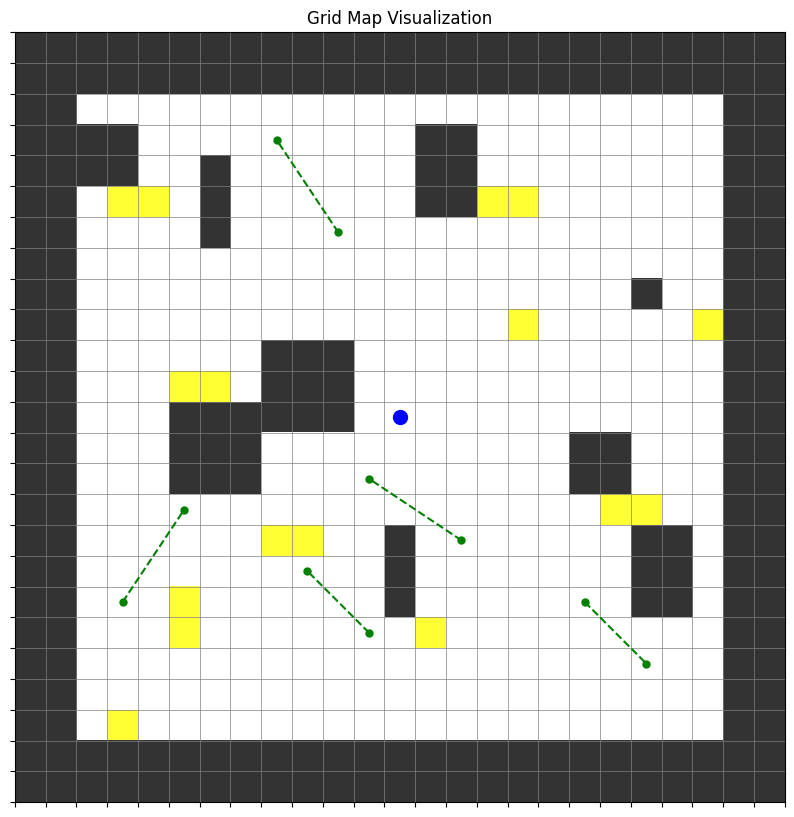

In [117]:
# 맵 생성 및 테스트
SIZE = 21
map = GridMap(size=SIZE, seed=42)

# 에이전트 위치 설정
agent_pos = (SIZE//2, SIZE//2)

# 10개의 랜덤한 장애물(가지 못하는 경로) 생성
map.add_random_obstacles(10)

# 10개의 랜덤한 공사중인 경로 생성
map.add_random_construction(10, agent_pos)

# 5개의 랜덤한 지름길 생성
map.add_random_shortcuts(5, agent_pos)

# 맵 시각화 (agent를 정중앙에 위치)
map.visualize(agent_pos)